<a href="https://colab.research.google.com/github/Altaieb-Mohammed/lab_2corse/blob/master/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Данные успешно загружены из URL.
Первые 5 строк датасета:
       debts   bequests  wife  husband  sons  daughters  father  mother  \
0   89083.21   47843.65     1        0     1          2       0       0   
1   89149.37  243374.33     1        0     5          5       1       0   
2     648.46   17774.84     0        1     3          1       0       0   
3   23549.63  165834.40     0        0     3          4       1       1   
4  199933.12  177838.94     1        0     5          4       1       0   

   brothers  sisters  ...  debts_standard  bequests_standard  wife_standard  \
0         3        3  ...        0.436273          -0.436317       1.273816   
1         0        1  ...        0.437485           2.607576       1.273816   
2         3        0  ...       -1.184573          -0.904409      -0.785043   
3         2        2  ...       -0.764837           1.400485      -0.785043   
4         2        3  ...        2.467948           1.587364       1.273816   

   husband_stand

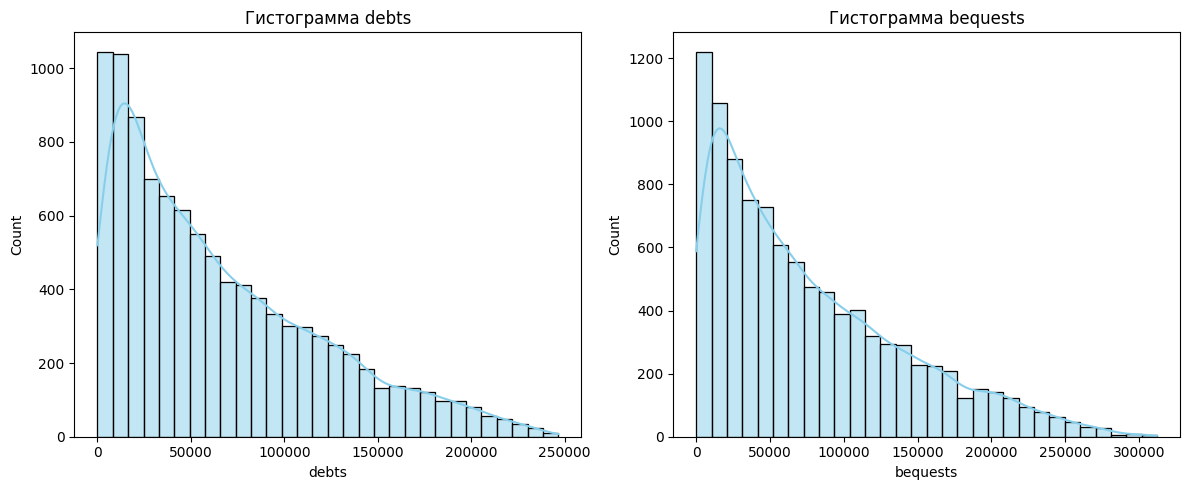

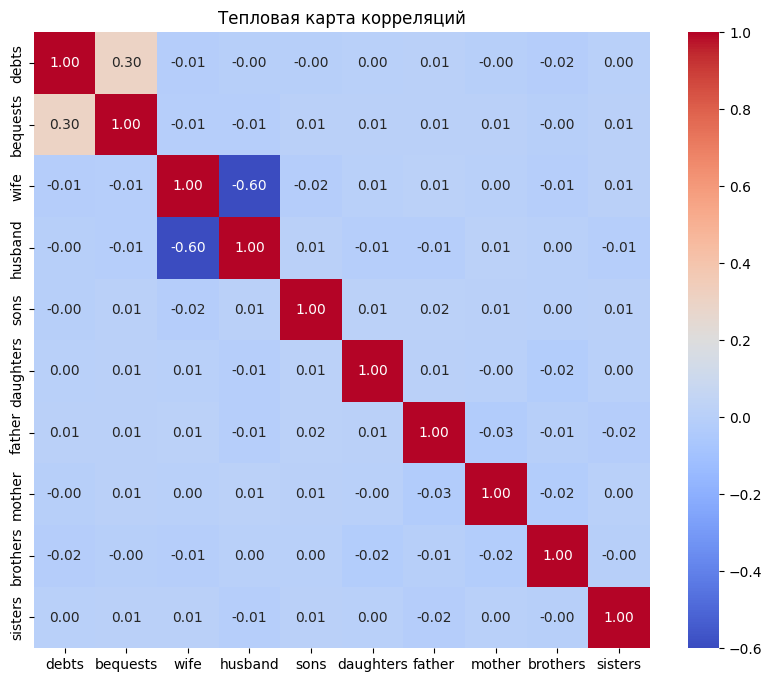

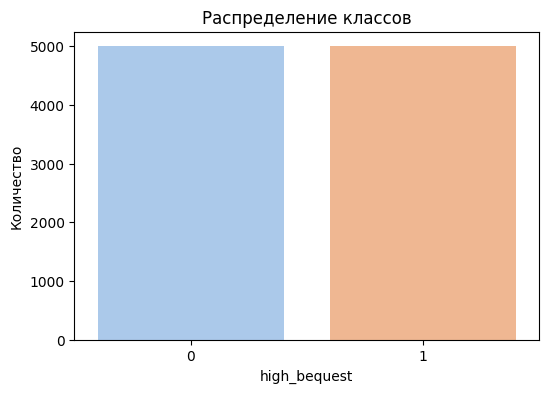


Баланс классов:
high_bequest
0    5000
1    5000
Name: count, dtype: int64

До SMOTE: Counter({0: 4000, 1: 4000})

KNN кросс-валидация F1-score: 0.5696 ± 0.0110
KNN обучена за 1.53 секунд

Отчёт классификации для KNN:
              precision    recall  f1-score   support

           0       0.58      0.59      0.58      1000
           1       0.58      0.57      0.58      1000

    accuracy                           0.58      2000
   macro avg       0.58      0.58      0.58      2000
weighted avg       0.58      0.58      0.58      2000



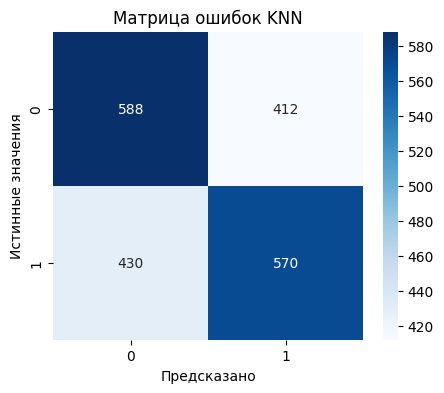

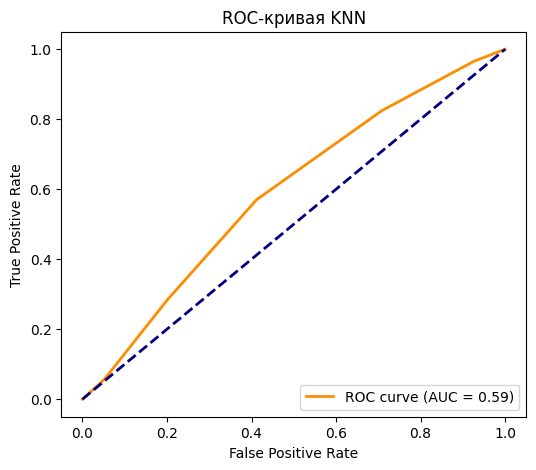

In [ ]:
#------------------------------------------lab3-----------------------------------------------
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
import time
from collections import Counter

# --- Helper plotting and evaluation functions ---

def plot_histograms(df, columns):
    plt.figure(figsize=(12, 5))
    for i, col in enumerate(columns, 1):
        plt.subplot(1, len(columns), i)
        sns.histplot(df[col], bins=30, kde=True, color='skyblue')
        plt.title(f'Гистограмма {col}')
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(df):
    plt.figure(figsize=(10, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title('Тепловая карта корреляций')
    plt.show()

def plot_class_distribution(df, target_col):
    plt.figure(figsize=(6,4))
    sns.countplot(x=target_col, data=df, palette='pastel')
    plt.title('Распределение классов')
    plt.xlabel(target_col)
    plt.ylabel('Количество')
    plt.show()

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    print(f"\nОтчёт классификации для {model_name}:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Матрица ошибок {model_name}')
    plt.xlabel('Предсказано')
    plt.ylabel('Истинные значения')
    plt.show()

    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.title(f'ROC-кривая {model_name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

def plot_pca_3d(X, y):
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='coolwarm', alpha=0.7)
    legend1 = ax.legend(*scatter.legend_elements(), title="Классы")
    ax.add_artist(legend1)
    ax.set_title('PCA 3D визуализация')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.show()

def plot_tsne_2d(X, y):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='coolwarm', alpha=0.7)
    plt.title('t-SNE 2D визуализация')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend(title='Классы')
    plt.show()

# --- Main pipeline ---

def load_data(url):
    try:
        df = pd.read_csv(url)
        print("Данные успешно загружены из URL.")
    except Exception as e:
        print(f"Ошибка загрузки данных: {e}")
        from google.colab import files
        uploaded = files.upload()
        df = pd.read_csv(next(iter(uploaded)))
        print("Данные успешно загружены из локального файла.")
    return df

url = "https://raw.githubusercontent.com/Altaieb-Mohammed/lab_2corse/master/inheritance_combined.csv"
df = load_data(url)
print("Первые 5 строк датасета:")
print(df.head())
# Проверяем структуру данных и пропуски
print("\nИнформация о данных:")
print(df.info())

print("\nСтатистика по пропущенным значениям:")
print(df.isnull().sum())

print("\nКоличество дубликатов:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

# Выбираем числовые признаки и удаляем пропуски
feature_columns = [
    'debts', 'bequests', 'wife', 'husband',
    'sons', 'daughters', 'father', 'mother', 'brothers', 'sisters'
]
df_clean = df[feature_columns].dropna()
print(f"\nРазмер данных после удаления пропусков: {df_clean.shape}")

# Визуализация распределения ключевых признаков
plot_histograms(df_clean, ['debts', 'bequests'])
plot_correlation_heatmap(df_clean)

# Создаём бинарный целевой признак high_bequest
median_bequest = df_clean['bequests'].median()
df_clean['high_bequest'] = (df_clean['bequests'] >= median_bequest).astype(int)
plot_class_distribution(df_clean, 'high_bequest')

# Проверяем баланс классов
class_counts = df_clean['high_bequest'].value_counts()
print(f"\nБаланс классов:\n{class_counts}")

# Разделяем признаки и целевой признак
X = df_clean.drop(columns=['high_bequest', 'bequests'])
y = df_clean['high_bequest']

# Разбиваем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Стандартизируем признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Проверяем баланс классов в обучающей выборке и применяем SMOTE при необходимости
print(f"\nДо SMOTE: {Counter(y_train)}")
if min(class_counts) / max(class_counts) < 0.5:
    smote = SMOTE(random_state=42)
    X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)
    print(f"После SMOTE: {Counter(y_train)}")

# Обучаем модели и оцениваем
models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced')
}

for name, model in models.items():
    start_time = time.time()
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
    print(f"\n{name} кросс-валидация F1-score: {scores.mean():.4f} ± {scores.std():.4f}")

    model.fit(X_train_scaled, y_train)
    end_time = time.time()
    print(f"{name} обучена за {end_time - start_time:.2f} секунд")

    evaluate_model(model, X_test_scaled, y_test, name)

# Подбираем лучшие параметры для KNN с помощью GridSearchCV
param_grid = {
    'n_neighbors': range(3, 15),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_knn = grid_search.best_estimator_
print(f'\nЛучшие параметры KNN: {grid_search.best_params_}')
evaluate_model(best_knn, X_test_scaled, y_test, "KNN (optimized)")

# Обучаем Random Forest для оценки важности признаков
forest = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
forest.fit(X_train_scaled, y_train)

feat_importances = pd.Series(forest.feature_importances_, index=X.columns).sort_values()
plt.figure(figsize=(10,6))
feat_importances.plot(kind='barh', color='teal')
plt.title('Важность признаков (Random Forest)')
plt.xlabel('Важность')
plt.show()

# Визуализация с помощью PCA и t-SNE
plot_pca_3d(X_train_scaled, y_train)
plot_tsne_2d(X_train_scaled, y_train)
